In [3]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch .optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load the dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls /content/drive/MyDrive


'Colab Notebooks'   dataset  'Google Earth'   images   Lahari_resume.pdf


In [7]:
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),       # Randomly flip images horizontally
    transforms.RandomRotation(10),           # Randomly rotate images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224,224)),  # Resize images to a fixed size
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to range [-1, 1]
])

In [8]:
# Load the entire dataset
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset', transform=image_transform)
len(dataset)

2300

In [34]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [10]:
num_classes = len(dataset.classes)
num_classes

6

## Perform train test split

In [11]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [12]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [14]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels.shape)
    break


torch.Size([32, 3, 224, 224])
torch.Size([32])


In [15]:
labels[0]

tensor(0)

In [ ]:
images[0].shape

torch.Size([3, 224, 224])

In [ ]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

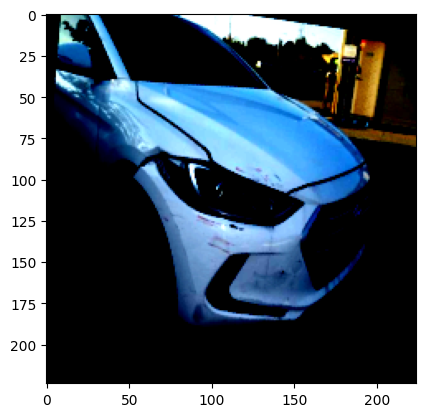

In [ ]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

# **Model 1** : CNN

In [20]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [21]:
images.size(0)

32

In [22]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")

    end = time.time()
    print(f"Execution time: {end - start} seconds")

    return all_labels, all_predictions

In [ ]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=2)

Batch: 10, Epoch: 1, Loss: 0.62
Batch: 20, Epoch: 1, Loss: 0.86
Batch: 30, Epoch: 1, Loss: 0.65
Batch: 40, Epoch: 1, Loss: 0.79
Batch: 50, Epoch: 1, Loss: 0.74
Epoch [1/2], Avg Loss: 0.6461
*** Validation Accuracy: 59.30% ***
Batch: 10, Epoch: 2, Loss: 0.49
Batch: 20, Epoch: 2, Loss: 0.35
Batch: 30, Epoch: 2, Loss: 0.47
Batch: 40, Epoch: 2, Loss: 0.70
Batch: 50, Epoch: 2, Loss: 0.32
Epoch [2/2], Avg Loss: 0.5328
*** Validation Accuracy: 62.26% ***
Execution time: 177.7000241279602 seconds


In [ ]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.82
Batch: 20, Epoch: 1, Loss: 1.88
Batch: 30, Epoch: 1, Loss: 1.73
Batch: 40, Epoch: 1, Loss: 1.71
Batch: 50, Epoch: 1, Loss: 1.70
Epoch [1/10], Avg Loss: 1.9486
*** Validation Accuracy: 34.96% ***
Batch: 10, Epoch: 2, Loss: 1.46
Batch: 20, Epoch: 2, Loss: 1.22
Batch: 30, Epoch: 2, Loss: 1.47
Batch: 40, Epoch: 2, Loss: 1.30
Batch: 50, Epoch: 2, Loss: 1.02
Epoch [2/10], Avg Loss: 1.3706
*** Validation Accuracy: 48.87% ***
Batch: 10, Epoch: 3, Loss: 1.44
Batch: 20, Epoch: 3, Loss: 1.03
Batch: 30, Epoch: 3, Loss: 1.20
Batch: 40, Epoch: 3, Loss: 1.46
Batch: 50, Epoch: 3, Loss: 1.16
Epoch [3/10], Avg Loss: 1.2384
*** Validation Accuracy: 48.87% ***
Batch: 10, Epoch: 4, Loss: 1.27
Batch: 20, Epoch: 4, Loss: 1.11
Batch: 30, Epoch: 4, Loss: 1.22
Batch: 40, Epoch: 4, Loss: 1.31
Batch: 50, Epoch: 4, Loss: 1.43
Epoch [4/10], Avg Loss: 1.1429
*** Validation Accuracy: 54.09% ***
Batch: 10, Epoch: 5, Loss: 0.99
Batch: 20, Epoch: 5, Loss: 1.00
Batch: 30, Epoch: 5, Loss: 0

Here if you observe the values it's a kind of overfitting condition

**Whenever there is overfitting we apply regularization**

# **Model 2:** CNN with Regularization

In [ ]:
class CarClassifierCNNwithregul(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [ ]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.78
Batch: 20, Epoch: 1, Loss: 1.79
Batch: 30, Epoch: 1, Loss: 1.80
Batch: 40, Epoch: 1, Loss: 1.79
Batch: 50, Epoch: 1, Loss: 1.80
Epoch [1/10], Avg Loss: 1.9530
*** Validation Accuracy: 25.22% ***
Batch: 10, Epoch: 2, Loss: 1.62
Batch: 20, Epoch: 2, Loss: 1.72
Batch: 30, Epoch: 2, Loss: 1.67
Batch: 40, Epoch: 2, Loss: 1.26
Batch: 50, Epoch: 2, Loss: 1.57
Epoch [2/10], Avg Loss: 1.6016
*** Validation Accuracy: 38.09% ***
Batch: 10, Epoch: 3, Loss: 1.55
Batch: 20, Epoch: 3, Loss: 1.49
Batch: 30, Epoch: 3, Loss: 1.41
Batch: 40, Epoch: 3, Loss: 1.32
Batch: 50, Epoch: 3, Loss: 1.31
Epoch [3/10], Avg Loss: 1.4729
*** Validation Accuracy: 40.52% ***
Batch: 10, Epoch: 4, Loss: 1.22
Batch: 20, Epoch: 4, Loss: 1.50
Batch: 30, Epoch: 4, Loss: 1.48
Batch: 40, Epoch: 4, Loss: 1.23
Batch: 50, Epoch: 4, Loss: 1.22
Epoch [4/10], Avg Loss: 1.3905
*** Validation Accuracy: 42.96% ***
Batch: 10, Epoch: 5, Loss: 1.38
Batch: 20, Epoch: 5, Loss: 1.23
Batch: 30, Epoch: 5, Loss: 1

After performing regularization there is no improvement in the accuracy, infact it got reduced
* This is due to less no. of images in dataset - So it would be better to Train on Transfer learning

# **Model 3:** Tranfer learning with EfficientNet

In [ ]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 124MB/s]


1280

In [24]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

1️⃣ Class Definition

2️⃣ The __init__ method

3️⃣ Load EfficientNet

```
 self.model = models.efficient_b0(weights='DEFAULT')
```
Loads EfficientNet-B0 pretrained model from torchvision.models.

weights='DEFAULT' means it uses ImageNet pretrained weights.

Pretrained models help with transfer learning (you don’t train from scratch).

4️⃣ Freeze Pretrained Layers

```

for param in self.model.parameters():
    param.requires_grad = False
```

Freezes all the layers of EfficientNet so their weights won’t change during training.

This is typical in transfer learning: you only train the final classifier layers.

In [ ]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.69
Batch: 20, Epoch: 1, Loss: 1.48
Batch: 30, Epoch: 1, Loss: 1.56
Batch: 40, Epoch: 1, Loss: 1.39
Batch: 50, Epoch: 1, Loss: 1.35
Epoch [1/10], Avg Loss: 1.4801
*** Validation Accuracy: 60.52% ***
Batch: 10, Epoch: 2, Loss: 1.24
Batch: 20, Epoch: 2, Loss: 1.16
Batch: 30, Epoch: 2, Loss: 1.27
Batch: 40, Epoch: 2, Loss: 1.10
Batch: 50, Epoch: 2, Loss: 0.95
Epoch [2/10], Avg Loss: 1.1451
*** Validation Accuracy: 63.48% ***
Batch: 10, Epoch: 3, Loss: 0.90
Batch: 20, Epoch: 3, Loss: 1.03
Batch: 30, Epoch: 3, Loss: 0.92
Batch: 40, Epoch: 3, Loss: 1.02
Batch: 50, Epoch: 3, Loss: 1.45
Epoch [3/10], Avg Loss: 1.0365
*** Validation Accuracy: 65.04% ***
Batch: 10, Epoch: 4, Loss: 1.09
Batch: 20, Epoch: 4, Loss: 1.12
Batch: 30, Epoch: 4, Loss: 0.98
Batch: 40, Epoch: 4, Loss: 1.22
Batch: 50, Epoch: 4, Loss: 0.92
Epoch [4/10], Avg Loss: 0.9544
*** Validation Accuracy: 64.52% ***
Batch: 10, Epoch: 5, Loss: 0.93
Batch: 20, Epoch: 5, Loss: 0.74
Batch: 30, Epoch: 5, Loss: 0

* filter(lambda p: p.requires_grad, model.parameters()) → only trains the parameters that are not frozen (i.e., the classifier).

# **Model 4:** Transfer Learning with ResNet

In [28]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


Batch: 10, Epoch: 1, Loss: 0.81
Batch: 20, Epoch: 1, Loss: 0.89
Batch: 30, Epoch: 1, Loss: 0.69
Batch: 40, Epoch: 1, Loss: 0.64
Batch: 50, Epoch: 1, Loss: 0.88
Epoch [1/10], Avg Loss: 0.8830
*** Validation Accuracy: 69.74% ***
Batch: 10, Epoch: 2, Loss: 0.41
Batch: 20, Epoch: 2, Loss: 0.39
Batch: 30, Epoch: 2, Loss: 0.48
Batch: 40, Epoch: 2, Loss: 0.49
Batch: 50, Epoch: 2, Loss: 0.67
Epoch [2/10], Avg Loss: 0.4660
*** Validation Accuracy: 73.74% ***
Batch: 10, Epoch: 3, Loss: 0.31
Batch: 20, Epoch: 3, Loss: 0.31
Batch: 30, Epoch: 3, Loss: 0.19
Batch: 40, Epoch: 3, Loss: 0.42
Batch: 50, Epoch: 3, Loss: 0.60
Epoch [3/10], Avg Loss: 0.3326
*** Validation Accuracy: 78.09% ***
Batch: 10, Epoch: 4, Loss: 0.20
Batch: 20, Epoch: 4, Loss: 0.14
Batch: 30, Epoch: 4, Loss: 0.20
Batch: 40, Epoch: 4, Loss: 0.04
Batch: 50, Epoch: 4, Loss: 0.12
Epoch [4/10], Avg Loss: 0.2161
*** Validation Accuracy: 76.35% ***
Batch: 10, Epoch: 5, Loss: 0.08
Batch: 20, Epoch: 5, Loss: 0.10
Batch: 30, Epoch: 5, Loss: 0

#Hyperparamter Tuning

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.1 MB/s eta 0:00:00


In [ ]:
import optuna

In [25]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)

    # Load the model
    model = CarClassifierResNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Training loop (using fewer epochs for faster hyperparameter tuning)
    epochs = 3
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_dataloader.dataset)

        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        # Report intermediate result to Optuna
        trial.report(accuracy, epoch)

        # Handle pruning (if applicable)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    end = time.time()
    print(f"Execution time: {end - start} seconds")

    return accuracy


In [ ]:
# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-11-03 11:05:58,613] A new study created in memory with name: no-name-4064faaa-cfe0-472e-bd3c-f4c80ac33922


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]
[I 2025-11-03 11:30:52,370] Trial 0 finished with value: 74.43478260869566 and parameters: {'lr': 8.649252973757078e-05, 'dropout_rate': 0.5684598860728004}. Best is trial 0 with value: 74.43478260869566.


Execution time: 1492.6071712970734 seconds


[I 2025-11-03 11:35:38,183] Trial 1 finished with value: 72.52173913043478 and parameters: {'lr': 4.95343746254485e-05, 'dropout_rate': 0.225894817518151}. Best is trial 0 with value: 74.43478260869566.


Execution time: 285.37327551841736 seconds


[I 2025-11-03 11:40:30,233] Trial 2 finished with value: 74.26086956521739 and parameters: {'lr': 0.004224929758402354, 'dropout_rate': 0.21925294500259013}. Best is trial 0 with value: 74.43478260869566.


Execution time: 291.6018793582916 seconds


[I 2025-11-03 11:45:23,541] Trial 3 finished with value: 78.08695652173913 and parameters: {'lr': 0.0035983669664969397, 'dropout_rate': 0.5425536745011612}. Best is trial 3 with value: 78.08695652173913.


Execution time: 292.7200508117676 seconds


[I 2025-11-03 11:50:15,147] Trial 4 finished with value: 79.47826086956522 and parameters: {'lr': 0.003560087030796235, 'dropout_rate': 0.31954713215225294}. Best is trial 4 with value: 79.47826086956522.


Execution time: 291.1661593914032 seconds


[I 2025-11-03 11:55:06,639] Trial 5 finished with value: 77.04347826086956 and parameters: {'lr': 0.00046650444803537943, 'dropout_rate': 0.2689854318688198}. Best is trial 4 with value: 79.47826086956522.


Execution time: 291.0499930381775 seconds


[I 2025-11-03 11:56:45,430] Trial 6 pruned. 
[I 2025-11-03 11:58:22,545] Trial 7 pruned. 
[I 2025-11-03 12:00:00,363] Trial 8 pruned. 
[I 2025-11-03 12:04:50,992] Trial 9 finished with value: 78.78260869565217 and parameters: {'lr': 0.0006621421538454787, 'dropout_rate': 0.644319428014136}. Best is trial 4 with value: 79.47826086956522.


Execution time: 289.9030439853668 seconds


[I 2025-11-03 12:08:05,002] Trial 10 pruned. 
[I 2025-11-03 12:12:55,650] Trial 11 finished with value: 78.95652173913044 and parameters: {'lr': 0.0007603267033795629, 'dropout_rate': 0.6477470570540007}. Best is trial 4 with value: 79.47826086956522.


Execution time: 290.15754652023315 seconds


[I 2025-11-03 12:17:46,488] Trial 12 finished with value: 79.47826086956522 and parameters: {'lr': 0.0010474320854439263, 'dropout_rate': 0.6902487454390639}. Best is trial 4 with value: 79.47826086956522.


Execution time: 290.1278643608093 seconds


[I 2025-11-03 12:19:22,998] Trial 13 pruned. 
[I 2025-11-03 12:22:36,861] Trial 14 pruned. 
[I 2025-11-03 12:24:13,817] Trial 15 pruned. 
[I 2025-11-03 12:29:00,762] Trial 16 finished with value: 78.78260869565217 and parameters: {'lr': 0.001553802975619945, 'dropout_rate': 0.47613680665308966}. Best is trial 4 with value: 79.47826086956522.


Execution time: 286.5059518814087 seconds


[I 2025-11-03 12:33:46,086] Trial 17 pruned. 
[I 2025-11-03 12:36:55,569] Trial 18 pruned. 
[I 2025-11-03 12:41:41,179] Trial 19 finished with value: 75.82608695652173 and parameters: {'lr': 0.00027144329344414757, 'dropout_rate': 0.42066206298595266}. Best is trial 4 with value: 79.47826086956522.


Execution time: 285.1752452850342 seconds


In [ ]:
study.best_params

{'lr': 0.003560087030796235, 'dropout_rate': 0.31954713215225294}

In [29]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0035)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]


Batch: 10, Epoch: 1, Loss: 0.79
Batch: 20, Epoch: 1, Loss: 1.63
Batch: 30, Epoch: 1, Loss: 0.74
Batch: 40, Epoch: 1, Loss: 0.99
Batch: 50, Epoch: 1, Loss: 0.47
Epoch [1/10], Avg Loss: 0.9575
*** Validation Accuracy: 70.43% ***
Batch: 10, Epoch: 2, Loss: 0.34
Batch: 20, Epoch: 2, Loss: 0.79
Batch: 30, Epoch: 2, Loss: 0.47
Batch: 40, Epoch: 2, Loss: 0.36
Batch: 50, Epoch: 2, Loss: 0.65
Epoch [2/10], Avg Loss: 0.5347
*** Validation Accuracy: 79.13% ***
Batch: 10, Epoch: 3, Loss: 0.61
Batch: 20, Epoch: 3, Loss: 0.27
Batch: 30, Epoch: 3, Loss: 0.66
Batch: 40, Epoch: 3, Loss: 0.61
Batch: 50, Epoch: 3, Loss: 0.34
Epoch [3/10], Avg Loss: 0.4189
*** Validation Accuracy: 77.22% ***
Batch: 10, Epoch: 4, Loss: 0.47
Batch: 20, Epoch: 4, Loss: 0.41
Batch: 30, Epoch: 4, Loss: 0.28
Batch: 40, Epoch: 4, Loss: 0.24
Batch: 50, Epoch: 4, Loss: 0.31
Epoch [4/10], Avg Loss: 0.3173
*** Validation Accuracy: 75.83% ***
Batch: 10, Epoch: 5, Loss: 0.42
Batch: 20, Epoch: 5, Loss: 0.29
Batch: 30, Epoch: 5, Loss: 0

# Model Evaluation using Confusion Matrix and Classification Report

In [31]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.73      0.82       124
           1       0.64      0.93      0.76       106
           2       0.96      0.82      0.89       129
           3       0.92      0.51      0.66        68
           4       0.64      0.84      0.72        75
           5       0.78      0.82      0.80        73

    accuracy                           0.79       575
   macro avg       0.81      0.78      0.78       575
weighted avg       0.83      0.79      0.79       575



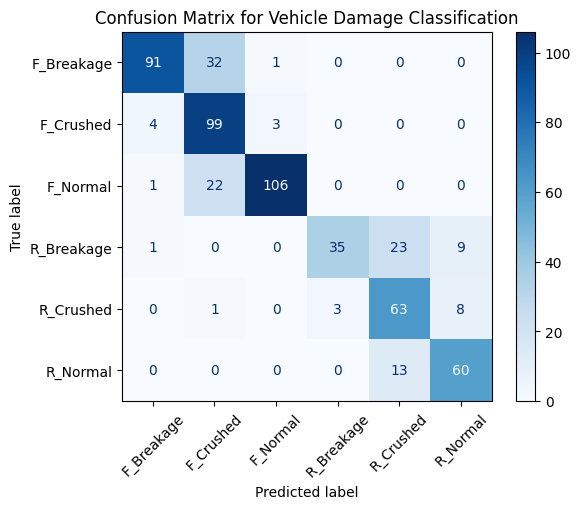

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

#Save the model


In [37]:
torch.save(model.state_dict(), 'saved_model.pth')

In [38]:
from google.colab import files
files.download('saved_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>